<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/Classical_demand_forecast_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up MLFlow

In [ ]:
!pip install mlflow --quiet

In [ ]:
import mlflow

## Connect storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!mkdir mlflow_results

In [ ]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [ ]:
# Set up experiment name. Keep the experiment name the same across all models for easy comparison
mlflow.set_experiment("Demand Forecast Experiment")

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/197750379659849961', creation_time=1729946473234, experiment_id='197750379659849961', last_update_time=1729946473234, lifecycle_stage='active', name='Demand Forecast Experiment', tags={}>

In [ ]:
#with mlflow.start_run(run_name="example_run"):
#    mlflow.log_param("param1", 5)
#    mlflow.log_metric("metric1", 0.87)

## Start MLFlow UI

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [ ]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://2763-34-48-29-39.ngrok-free.app" 


# Import all libraries we will need for the modeling and evaluation

In [ ]:
!pip install darts --quiet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import mlflow.pyfunc
from sklearn.metrics import mean_absolute_error, mean_squared_error

from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mae, mape, rmse

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Read the files with pandas

In [ ]:
# Load the CSV file into pandas DataFrame

#Note: train file is very large.
#To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.5e7)
# Convert 'date' column to datetime in the train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

<ipython-input-60-925167111847>:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.5e7)


# Prepare data

## For the quick experimenting, we will select one store-product pair

In [ ]:
#df_train[(df_train['store_nbr'] == store_id)]['item_nbr'].value_counts()

In [ ]:
#store_id = [1]
store_id = df_train['store_nbr'].unique() #all stores
item_id = [564533,838216]
df_filtered = df_train[(df_train['store_nbr'].isin(store_id)) & (df_train['item_nbr'].isin(item_id))]

# Group by date and aggregate sales
df_filtered = df_filtered.groupby(['store_nbr','item_nbr','date']).sum()['unit_sales'].reset_index()

del df_train #clean-up memory, we don't need this dataframe

## Feature engineering

In [ ]:
data = df_filtered.copy() #we can easy switch between df_filtered and full dataset by assigning it to data variable

## Fill out missing dates with 0 sales

In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = data['date'].min()
max_date = data['date'].max()
print(min_date.date(), max_date.date())

# Create a full date range covering all days between the min and max dates
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in data.groupby(['store_nbr', 'item_nbr']):
    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

2013-01-01 2014-06-07


In [ ]:
data = df_filled.copy()

In [ ]:
data.head(3)

,date,store_nbr,item_nbr,unit_sales
0,2013-01-01,1,564533,0.0
1,2013-01-02,1,564533,22.0
2,2013-01-03,1,564533,15.0


# Split in test and train datasets

In [ ]:
split_date = '2014-03-01'
train = data[data['date'] < split_date]
test = data[data['date'] >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)

Train dataframe shape: (40704, 4)
Test dataframe shape: (9504, 4)


# Forecast with ARIMA

# Loop Through Each Product-Store Pair and Apply ARIMA Separately
The ARIMA model in Darts is designed for univariate time series forecasting, meaning it works with a single time series at a time. If you have a dataset with multiple time series (e.g., different product-store pairs), you cannot directly apply a single ARIMA model across the entire DataFrame. Instead, you'll need to handle each time series individually.

In the code below we fit the model for each store-item pair and log the results in MLFlow.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


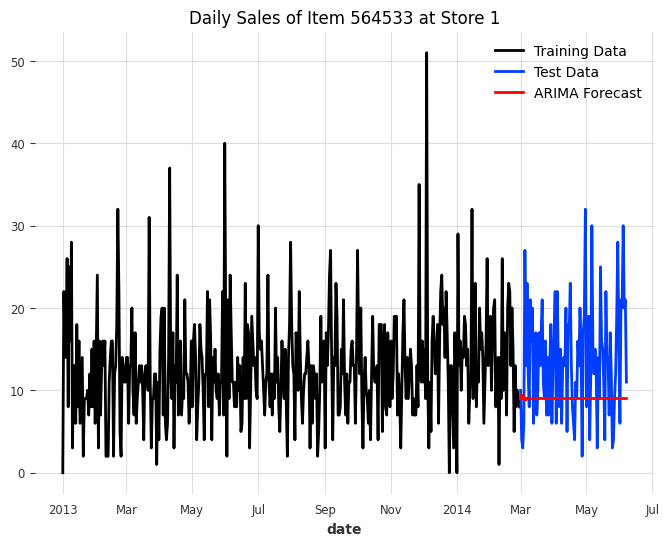

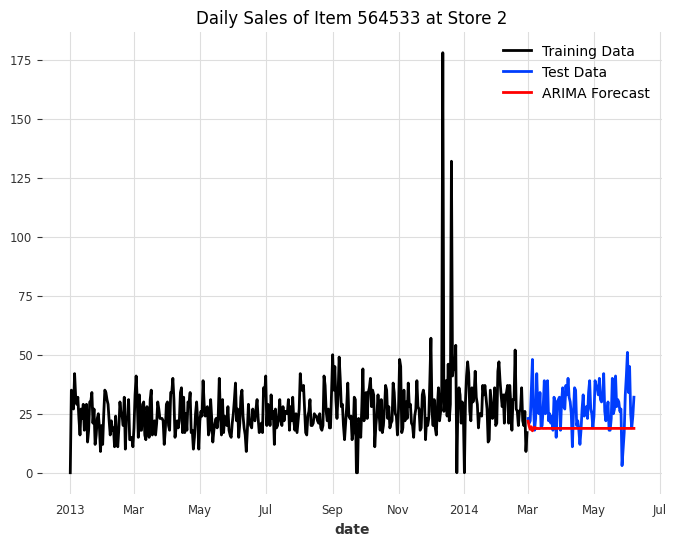

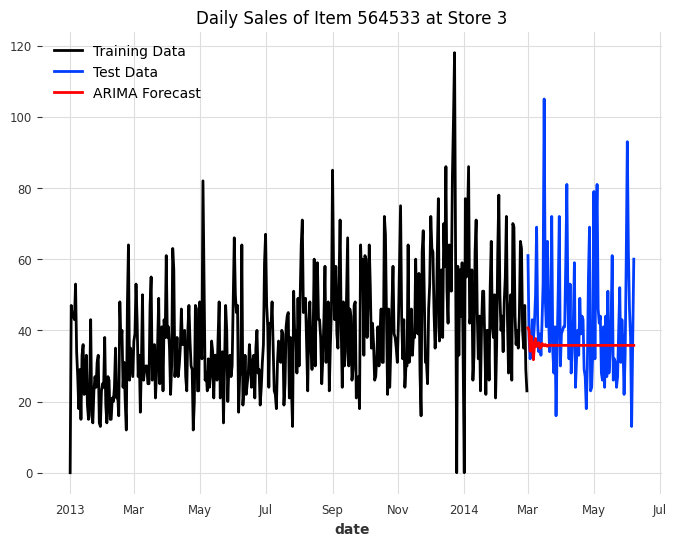

In [ ]:
import os
from tempfile import TemporaryDirectory

# Loop over each product-store pair
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count = 0

with mlflow.start_run(run_name="arima_run"):
    # Log ARIMA parameters only once for the whole run
    mlflow.log_param("p", 5)
    mlflow.log_param("d", 1)
    mlflow.log_param("q", 0)

    for (item_nbr, store_nbr), group in data.groupby(['item_nbr', 'store_nbr']):
        group = group.groupby(['date']).sum()['unit_sales'].reset_index()
        train_series = TimeSeries.from_dataframe(group[group['date'] < split_date], value_cols='unit_sales', time_col='date', fill_missing_dates=True, freq='D')
        train_series += 1e-5  # Add a small constant to make all values positive
        test_series = TimeSeries.from_dataframe(group[group['date'] >= split_date], value_cols='unit_sales', time_col='date', fill_missing_dates=True, freq='D')
        test_series += 1e-5  # Add a small constant to make all values positive

        # Initialize ARIMA model with (p, d, q) parameters
        arima_model = ARIMA(p=5, d=1, q=0)  # ARIMA(p, d, q)

        # Fit the ARIMA model on the training data
        arima_model.fit(train_series)

        # Forecast the next values (the same length as the test set)
        arima_forecast = arima_model.predict(len(test_series))

        # Save and log model as an artifact
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"arima_model_store_{store_nbr}_item_{item_nbr}.pkl")
            arima_model.save(model_path)  # Save ARIMA model
            mlflow.log_artifact(model_path, artifact_path=f"models/arima_store_{store_nbr}_item_{item_nbr}")

        # Optional: plot forecast vs actual data for a subset
        if plot_count < 3:
            plt.figure(figsize=(8, 6))  # Adjust the figure size (width, height)
            train_series.plot(label='Training Data')
            test_series.plot(label='Test Data')
            arima_forecast.plot(label='ARIMA Forecast', color='red')
            plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}')
            file_path = f'ARIMA_forecast_store_{store_nbr}_item_{item_nbr}.png'
            plt.savefig(file_path)  # Saves the plot as a PNG file
            plot_paths.append(file_path)
            plot_count += 1

        # Calculate metrics
        bias_value = (arima_forecast.values() - test_series.values()).mean()
        bias_values.append(bias_value)
        rmse_value = rmse(test_series, arima_forecast)
        rmse_values.append(rmse_value)
        mae_value = mae(test_series, arima_forecast)
        mean_actual = test_series.values().mean()
        rmad_value = mae_value / mean_actual
        rmad_values.append(rmad_value)

    # Log average metrics across all models
    mlflow.log_metric("Average_rMAD", sum(rmad_values) / len(rmad_values))
    mlflow.log_metric("Average_Bias", sum(bias_values) / len(bias_values))
    mlflow.log_metric("Average_RMSE", sum(rmse_values) / len(rmse_values))

    # Log plots
    for plot_path in plot_paths:
        mlflow.log_artifact(plot_path, artifact_path="plots")


In [ ]:
#To read the models later:
#from darts.models import ARIMA
#arima_model = ARIMA.load("path_to_downloaded_model.pkl")

# Next steps

Now you can change the paramters of the model, fit the new model and compare the metrics in MLFlow. Everytime you change something, don't forget to give it different run name, so you easily distingfish various iterations later.